In [ ]:
! pip install -q kaggle

In [ ]:
! pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 17 kB/s 
     |████████████████████████████████| 1.7 MB 41.9 MB/s 
     |████████████████████████████████| 438 kB 53.1 MB/s 
     |████████████████████████████████| 5.9 MB 35.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5

In [ ]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 104MB/s]


In [ ]:
! unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd

train = pd.read_csv("train.csv")

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train["text"].size

7613

In [ ]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import 	WordNetLemmatizer

def tweet_to_wordlist(tweet):
    tweet_text = re.sub("[^a-zA-Z]","", tweet)

    words = tweet_text.lower().split()

    stops = set(stopwords.words("english"))

    #wordnet_lemmatizer = WordNetLemmatizer()

    #words = [wordnet_lemmatizer.lemmatize(w) for w in words if not w in stops ]

    return(words)

In [ ]:
train["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [ ]:
tweet_to_wordlist(train["text"][0])

['our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 'earthquake',
 'may',
 'allah',
 'forgive',
 'us',
 'all']

In [ ]:
test = pd.read_csv("test.csv")

In [ ]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


(array([ 277.,  545.,  803., 1177., 1648., 2520., 2146., 1305.,  401.,
          54.]),
 array([ 1. ,  4.2,  7.4, 10.6, 13.8, 17. , 20.2, 23.4, 26.6, 29.8, 33. ]),
 <a list of 10 Patch objects>)

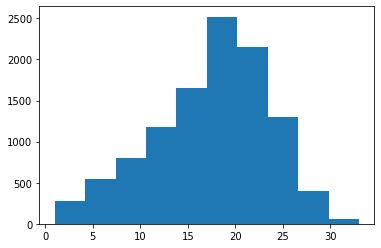

In [ ]:
import matplotlib.pyplot as plt

X = []
lens = []
for tweet in train["text"]:
  X.append(tweet_to_wordlist(tweet))
  lens.append(len(X[-1]))
for tweet in test["text"]:
  X.append(tweet_to_wordlist(tweet))
  lens.append(len(X[-1]))
plt.hist(lens)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

tok = Tokenizer()
tok.fit_on_texts(X)
vocab_size = len(tok.word_index) + 1
X_encd = tok.texts_to_sequences(X)
X_pad= pad_sequences(X_encd, maxlen=20, padding='post')

In [ ]:
X_pad.shape

(10876, 20)

In [ ]:
X_pad[0]

array([ 119, 6034,   27,    4,  832,    9,   22,  264,  167, 1788, 3974,
         90,   43,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
num_features = 200
min_word_count = 5
num_workers = 4
context = 5
downsampling = 1e-3

from gensim.models import word2vec

wv_model = word2vec.Word2Vec(X, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

vocab = set(wv_model.wv.index2word)

In [ ]:
len(vocab)

3973

In [ ]:
import numpy as np

embed_matrix=np.zeros(shape=(vocab_size,num_features))

for word,i in tok.word_index.items():
  if word in vocab:  # word is in the vocabulary learned by the w2v model
    embed_vector=wv_model[word]
    embed_matrix[i]=embed_vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [ ]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras import Sequential

model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=num_features,input_length=20,embeddings_initializer=Constant(embed_matrix)))
model.add(LSTM(40,dropout=0.7))
model.add(Dense(40,activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 20, 200)           5704800   
                                                                 
 lstm_39 (LSTM)              (None, 40)                38560     
                                                                 
 dense_57 (Dense)            (None, 40)                1640      
                                                                 
 dropout_31 (Dropout)        (None, 40)                0         
                                                                 
 dense_58 (Dense)            (None, 1)                 41        
                                                                 
Total params: 5,745,041
Trainable params: 5,745,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='binary_crossentropy',optimizer=Adam(0.001),metrics=['accuracy'])

In [ ]:
X_train = X_pad[:train.shape[0]]

In [ ]:
Y_train = np.array(train["target"])

In [ ]:
history = model.fit(X_train, Y_train,
                    batch_size=128,
                    epochs=5,
                    validation_split=0.1,
                    verbose=1)

Epoch 1/5
54/54 [==============================] - 10s 121ms/step - loss: 0.6595 - accuracy: 0.6106 - val_loss: 0.6140 - val_accuracy: 0.6837
Epoch 2/5
54/54 [==============================] - 6s 109ms/step - loss: 0.6152 - accuracy: 0.6720 - val_loss: 0.5388 - val_accuracy: 0.7415
Epoch 3/5
54/54 [==============================] - 6s 110ms/step - loss: 0.5075 - accuracy: 0.7778 - val_loss: 0.4651 - val_accuracy: 0.7848
Epoch 4/5
54/54 [==============================] - 6s 120ms/step - loss: 0.4007 - accuracy: 0.8403 - val_loss: 0.5206 - val_accuracy: 0.7546
Epoch 5/5
54/54 [==============================] - 6s 111ms/step - loss: 0.2840 - accuracy: 0.9016 - val_loss: 0.5220 - val_accuracy: 0.7808


In [ ]:
X_test = X_pad[train.shape[0]:]

In [ ]:
y_hat = model.predict(X_test)

102/102 [==============================] - 1s 6ms/step


In [ ]:
y_hat.shape

(3263, 1)

In [ ]:
y_hat = np.round(y_hat)
y_hat = y_hat.astype('int')

In [ ]:
output = pd.DataFrame( data={"id":test["id"], "target":y_hat.reshape(-1)})

output.to_csv( "LSTM_Word2Vec.csv", index=False)

In [ ]:
output.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
!kaggle competitions submit -c nlp-getting-started -f LSTM_Word2Vec.csv -m "Notes"

100% 22.2k/22.2k [00:00<00:00, 114kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets